# Making initial imports

In [148]:
#!pip install langdetect
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

In [149]:
# NLP library imports
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/po/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/po/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Loading data scrapped on TrustPilot

The dataframe is  composed with the comments scraped on Trustpolit at [this page](https://fr.trustpilot.com/review/www.centerparcs.fr/fr-fr).

In [183]:
df = pd.read_json('tripadvisorenfinal1.json')


# Shapping dataFrame

**Making some modifications from raw data**

In [184]:
# Deleting '\n' from content and name columns
from datetime import datetime
import dateparser

clean_n = lambda x: ' '.join(x.split()).lower()

df = df[["review","published_date","reviewer_id","rating","title", "review_language", "trip_date", "trip_type"]]
df.columns = ["content","date","name","stars","title","review_language", "trip_date" , "trip_type"]
df = df.dropna(axis=0, subset=['date'])

df.date = df.date.apply(lambda s: datetime.strptime(s, '%B %d, %Y'))
import dateparser # $ pip install dateparser
i = 0
#for date_string in df.date:
#    df.date[i] = dateparser.parse(date_string).date()
#    i = i +1

for col in ['name', 'content']:
    df[col] = df[col].apply(clean_n)
df = df[["content","date","name","stars","title", "trip_date", "review_language", "trip_type"]]
# Setting date as index
df.set_index('date', inplace = True)

#  Displaying result
df.head()

,content,name,stars,title,trip_date,review_language,trip_type
date,,,,,,,
2013-12-08,"we\'ve just returned from a midweek break, we ...",ac7ae042f6d08ea45c748f0d8aa73830,3,"I LOVE LOVE LOVE CENTER PARCS, BUT WHATS HAPPE...",December 2013,en,None
2013-12-09,this was our first visit and certainly won\'t ...,af4a7072d1181f20987a94804077f8b7,5,Terrific family break,December 2013,en,None
2013-12-09,we went to longleat for a mid week break for m...,523b12d984e439636da0cf7880ec3174,5,"Romantic Mid week break, FANTASTIC!",December 2013,en,None
2013-12-09,i visited centre parcs with my children at the...,6f79f8336eb6ba0abe0af43c1069fada,5,Relaxing break second time around..,December 2013,en,None
2013-12-09,just had a weekend break at center parcs longl...,c543f6bf0bebe533ae42c5690cec09d5,4,Center Parcs Longleat Forest,December 2013,en,None


# Exploratory Data Analysis

In [185]:
# Even if not really useful for this case, a good habit is to start with df.describe() and df.info() when you start working on a dataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3170 entries, 2013-12-08 to 2005-09-13
Data columns (total 7 columns):
content            3170 non-null object
name               3170 non-null object
stars              3170 non-null int64
title              3170 non-null object
trip_date          3160 non-null object
review_language    3170 non-null object
trip_type          101 non-null object
dtypes: int64(1), object(6)
memory usage: 198.1+ KB


**Studying eventual doubles**

- We're here looking at names which are pseudos. Be careful, differents people could use the same ones. The date is a good indicator to know if the same person let 2 comments.

In [186]:


print('Number of comments', df.name.count())
print('Number of unique names: ', df.name.nunique())

double = df.name.value_counts().index.tolist()[:sum(df.name.value_counts()>=2)]
for name in double:
    print('\n',name)
    date_double = df[df.name==name].index.tolist()
    content_double = df[df.name==name].content.tolist()
    [print(date,content) for date,content in zip(date_double,content_double)]

Number of comments 3170
Number of unique names:  3048

 2e7e8588f675d25f883054869bb730b5
2013-04-06 00:00:00 my husband and two young daughters (7&amp;3) returned yesterday from our 10th visit to longleat and you\'ll see from our previous reviews that we have always rated our stays as excellent however this time i do have to mark the stay down slightly. first the good points:- we stayed in a two bedroom (one double, one twin) woodland lodge right by the plaza, in the ash area. as always it was spacious, well equipped, warm &amp; cosy. there is a main bathroom, containing a bath with shower attachment. there is also a wc out in the hallway, however see negative points below.- staff very pleasant, friendly, helpful &amp; efficient as always. - wide range of activities available but most do cost extra. indicative prices can be found on the website before booking to give you an idea of what these extras will cost. we enjoyed mini bowling, indoor putting, snooker, a massage and our daughter

You might find interesting things in your dataset. 

For example it is fun here to see **Peltier**'s comments and how he changed is mind:

- April 14th 13:41 : "formule intéressante pour de courtes vacances"
- April 14th 20:33 : "pas de réseau et deux chaines tv manquantes" 



**Rapid overview of global rating**


Average rating is : 4.08


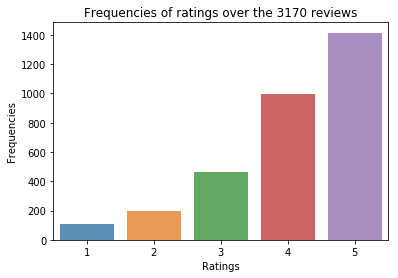

In [187]:
# Average rating value
print('Average rating is : {}'.format(round(df.stars.mean(),2)))

# Plotting rating distribution
X_ratings = df.stars.value_counts()
ax = sns.barplot(X_ratings.index,X_ratings,alpha=0.8)
ax.set(xlabel='Ratings',ylabel='Frequencies',title='Frequencies of ratings over the {} reviews'.format(df.shape[0]))
plt.show()

**Distribution of comments length**

/Users/po/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


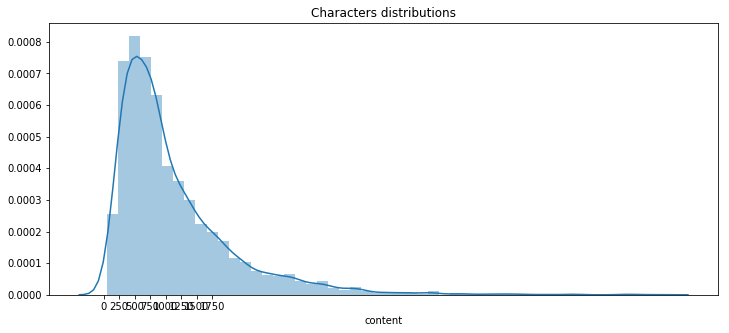

In [188]:
# Making the plot
x = plt.figure(figsize=(12,5))
sns.distplot(df['content'].apply(len))
plt.title('Characters distributions')
plt.xticks(range(0,2000,250))
plt.show()


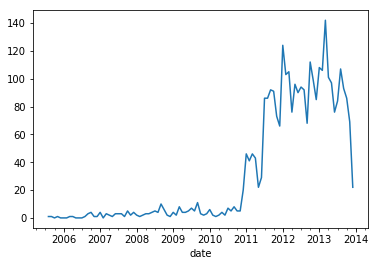

In [189]:
# Repartition of reviews dates

df.head()
df['content'].resample('M').count().plot()

# Pre-Processing 1 : Filters for punctuation and specific characters

In [190]:
# creating a list with all reviews
all_reviews = df.content.tolist()

In [191]:
# transformating comments into lower-case text 
lower_reviews = [review.lower() for review in all_reviews]

In [192]:
# deleting all specific caracters
characters_to_remove = ["@", "/", "#", ".", ",", "!", "?", "(", ")", "-", "_","’","'", "\"", ":"]
transformation_dict = {initial:" " for initial in characters_to_remove}
no_punctuation_reviews = [review.translate(str.maketrans(transformation_dict)) for review in lower_reviews]

In [193]:
# removing accent
with_accent = ['é', 'è', 'à']
without_accent = ['e', 'e', 'a']
transformation_dict = {before:after for before, after in zip(with_accent, without_accent)}
no_accent_reviews = [review.translate(str.maketrans(transformation_dict)) for review in no_punctuation_reviews]

In [194]:
# Displaying some results 
for i in range(5):
    print(all_reviews[i])
    print(no_accent_reviews[i])
    print('\n')

we\'ve just returned from a midweek break, we were sooooo excited having been last year. but with a grand cafe table mistake and very uncharacteristic rudeness from staff. a forty minute wait to see father christmas ( be warned your allocated time doesn\'t mean anything!) a ten minute horse and carriage ride!!! thank goodness for the pantomime and the subtropical pool!!! our four year old remained oblivious to all our issues which was the main thing..... hopefully it was just a minor blip as the staff are just getting into winterwonderland spirit, but lots of room for improvement as our stay last year had been magical from start to finish, definitely wasn\'t that this year - sorry center parcs - previous biggest fan :(
we\ ve just returned from a midweek break  we were sooooo excited having been last year  but with a grand cafe table mistake and very uncharacteristic rudeness from staff  a forty minute wait to see father christmas   be warned your allocated time doesn\ t mean anything 

In [195]:
def number_of_unique_words(list_of_reviews):
  
    # Concatenating all reviews from the list
    all_words = ''.join(list_of_reviews)

    # Tokenizing
    unique_tokens = set(word_tokenize(all_words))
  
    # Returning length of list
    return len(unique_tokens)

In [196]:
print(number_of_unique_words(all_reviews))

23416


In [197]:
print(number_of_unique_words(lower_reviews))

23416


In [198]:
print(number_of_unique_words(no_punctuation_reviews))

16132


In [199]:
print(number_of_unique_words(no_accent_reviews))

16132


# Pre-processing 2 : Tokenization

**Doing it in two different ways**

In [200]:
# Using regular expression
tokenized_reviews_re = [re.split('\s+', review) for review in no_accent_reviews]

In [201]:
# using NLP libraries
tokenized_reviews_nltk = [word_tokenize(review) for review in no_accent_reviews]

**And making a comparison of results**

In [202]:
# Making a comparison between both of them
print("With NLTK  library : {}".format(len(tokenized_reviews_nltk)))
print("With RegEx library : {}".format(len(tokenized_reviews_re)))

With NLTK  library : 3170
With RegEx library : 3170


**Try to analyze the next lines of code and to understand the difference between both of them**

Here is an original review

In [203]:
# Choosing a review to inspect
n_review = 10
print(all_reviews[n_review])

we were here to celebrate a special birthday. there were 3 generations in one lodge. we were a bit apprehensive but needn\'t have worried. there was loads of room - 4 bedrooms all en suite and with its own balcony. there were 2 fridges and very adequate cooking facilities which we used as we knew it would be expensive for 6 adults and 3 children to eat out. we used the pool area a lot - with children in the day and adults only in the evening. we hired bikes for us all to get around, its been a long time since i last cycled! the &quot;girls&quot; used the spa which is amazing - highly recommended. all in all, a great family short break.


And here are the tokenized ones

In [204]:
print(tokenized_reviews_nltk[n_review])

['we', 'were', 'here', 'to', 'celebrate', 'a', 'special', 'birthday', 'there', 'were', '3', 'generations', 'in', 'one', 'lodge', 'we', 'were', 'a', 'bit', 'apprehensive', 'but', 'needn\\', 't', 'have', 'worried', 'there', 'was', 'loads', 'of', 'room', '4', 'bedrooms', 'all', 'en', 'suite', 'and', 'with', 'its', 'own', 'balcony', 'there', 'were', '2', 'fridges', 'and', 'very', 'adequate', 'cooking', 'facilities', 'which', 'we', 'used', 'as', 'we', 'knew', 'it', 'would', 'be', 'expensive', 'for', '6', 'adults', 'and', '3', 'children', 'to', 'eat', 'out', 'we', 'used', 'the', 'pool', 'area', 'a', 'lot', 'with', 'children', 'in', 'the', 'day', 'and', 'adults', 'only', 'in', 'the', 'evening', 'we', 'hired', 'bikes', 'for', 'us', 'all', 'to', 'get', 'around', 'its', 'been', 'a', 'long', 'time', 'since', 'i', 'last', 'cycled', 'the', '&', 'quot', ';', 'girls', '&', 'quot', ';', 'used', 'the', 'spa', 'which', 'is', 'amazing', 'highly', 'recommended', 'all', 'in', 'all', 'a', 'great', 'family',

In [205]:
print(tokenized_reviews_re[n_review])

['we', 'were', 'here', 'to', 'celebrate', 'a', 'special', 'birthday', 'there', 'were', '3', 'generations', 'in', 'one', 'lodge', 'we', 'were', 'a', 'bit', 'apprehensive', 'but', 'needn\\', 't', 'have', 'worried', 'there', 'was', 'loads', 'of', 'room', '4', 'bedrooms', 'all', 'en', 'suite', 'and', 'with', 'its', 'own', 'balcony', 'there', 'were', '2', 'fridges', 'and', 'very', 'adequate', 'cooking', 'facilities', 'which', 'we', 'used', 'as', 'we', 'knew', 'it', 'would', 'be', 'expensive', 'for', '6', 'adults', 'and', '3', 'children', 'to', 'eat', 'out', 'we', 'used', 'the', 'pool', 'area', 'a', 'lot', 'with', 'children', 'in', 'the', 'day', 'and', 'adults', 'only', 'in', 'the', 'evening', 'we', 'hired', 'bikes', 'for', 'us', 'all', 'to', 'get', 'around', 'its', 'been', 'a', 'long', 'time', 'since', 'i', 'last', 'cycled', 'the', '&quot;girls&quot;', 'used', 'the', 'spa', 'which', 'is', 'amazing', 'highly', 'recommended', 'all', 'in', 'all', 'a', 'great', 'family', 'short', 'break', '']


In [206]:
# We select the secon one which seems more accurate
tokenized_reviews = tokenized_reviews_nltk

# Pre-processing 3 : Stopword removing

In [208]:
# Using a list with words to delete
stopW = stopwords.words('english')

In [209]:
# Customizing it with our needs
stopW += ['les', 'a', 'tout']

In [210]:
# Stopword_list
stopword_reviews = [[token for token in review if token not in stopW] for review in tokenized_reviews]
              

# Some visualization about what we've done

In [211]:
def plot_frequent_words(list_of_words):    
    dist = nltk.FreqDist(list_of_words)
    X = [nb[1] for nb in dist.most_common(20)]
    y = [nb[0] for nb in dist.most_common(20)]
    ax = sns.barplot(X,y)
    ax.set(xlabel='Word frequencies',ylabel='Words',title='Most common words in the corpus')
    plt.show()

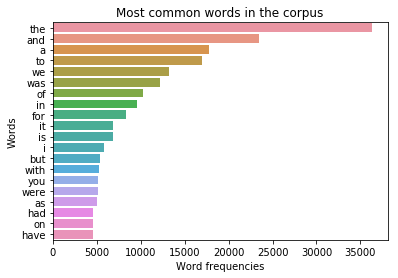

655146


In [212]:
# Making a first plot with original data
all_words = []
for review in all_reviews:
    for word in review.split():
        all_words.append(word)

plot_frequent_words(all_words)
print(len(all_words))

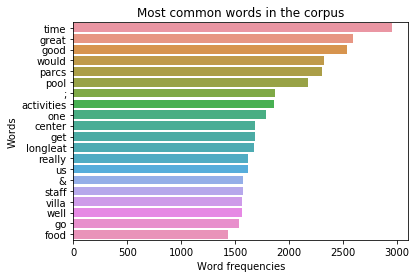

342813


In [213]:
# And making it with our current data
all_words = []
for review in stopword_reviews:
    for word in review:
        all_words.append(word)

plot_frequent_words(all_words)
print(len(all_words))
df.to_csv("Datacleanedgroup11en2.csv", index=True)



...Much better ! Isn't it ?

# TO DO : Now you can apply all of these methods to your own DataFrame


**The purpose is to create a second column with reviews content but processed and tokenized**

In [220]:
dfen1 = pd.read_csv('Datacleanedgroup11en1.csv')
dfen2 = pd.read_csv('Datacleanedgroup11en2.csv')
dffr = pd.read_csv('Datacleanedgroup11fr1.csv')

dffr.head
dfnew = pd.concat([dfen1, dfen2], axis=0)
print(dfnew.shape)
dfnew = pd.concat([dfnew, dffr], axis=0)
dfnew.to_csv("Datacleanedfinal.csv", index=True)


(9897, 8)


# BONUS : A little exercice about RegEx

**Try some patterns on the next strings**

You can use the different functions
- re.split() : to split my_string on the pattern and print the result.
- re.findall() : find all the occurences matching the pattern in the total string.

In [ ]:
import re
my_string = "Let's write RegEx!"

PATTERN = r"\s+"
# PATTERN = r"[a-z]"
# PATTERN = r"\w"
# PATTERN = r"\w+"

In [ ]:
re.findall(PATTERN, my_string)

In [ ]:
re.split(PATTERN, my_string)

**Given the table show in course, try to make the following match**

In [ ]:
# Write a pattern to match sentence endings: sentence_endings
sentence_endings = r"[___]"

# Split my_string on sentence endings and print the result
print(re.____(____, ____))

In [ ]:
# Find all capitalized words in my_string and print the result
capitalized_words = r"[___]\w+"
print(re.____(____, ____))

In [ ]:
# Split my_string on spaces and print the result
spaces = r"___"
print(re.____(____, ____))

In [ ]:
# Find all digits in my_string and print the result
digits = r"___"
print(re.____(____, ____))